In [4]:
from __future__ import print_function, division

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from load_dataset import BangladeshDataset
from utils import torch_to_im_show
import matplotlib.pyplot as plt
import time
import os
import gdal

gdal.SetCacheMax(2**30) # 1 GB

plt.ion()   # interactive mode
%matplotlib inline

In [5]:
#train_data_dir = '/mnt/staff-bucket/'
#val_data_dir = '/mnt/staff-bucket/'

train_data_dir = '/mnt/mounted_bucket'
val_data_dir = '/mnt/mounted_bucket'

train_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_train.csv'
val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid.csv'


train_dataset = BangladeshDataset(csv_file=train_bangladesh_csv_path,
                                           root_dir=train_data_dir)
val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path,
                                           root_dir=val_data_dir)

image_datasets = {'train': train_dataset, 'val': val_dataset}

Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_1.0.tif...
0 (500, 500, 3) 89.9941918102
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_2.0.tif...
1 (500, 500, 3) 70.1737349915
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_3.0.tif...
2 (500, 500, 3) 46.5523593667
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_4.0.tif...
3 (500, 500, 3) 173.793704805


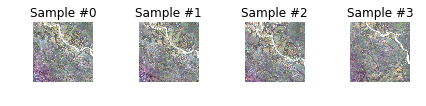

In [8]:
# visualize a few images from training set
fig = plt.figure()

for i in range(len(image_datasets['train'])):
    image, label = image_datasets['train'][i]
    image = np.array(image)

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    # expects images with shape image.shape = (500, 500, 3)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

    if i == 3:
        plt.show()
        break

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data_dir = '/mnt/mounted_bucket'
val_data_dir = '/mnt/mounted_bucket'

train_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_train.csv'
val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid.csv'


train_dataset = BangladeshDataset(csv_file=train_bangladesh_csv_path,
                                           root_dir=train_data_dir,
                                           transform=data_transforms['train'])
val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path,
                                           root_dir=val_data_dir,
                                           transform=data_transforms['val'])

image_datasets = {'train': train_dataset, 'val': val_dataset}

dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [13]:
dataset_sizes

{'train': 5472, 'val': 1198}

Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_1.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_2.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_3.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_4.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_5.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_6.0.tif...


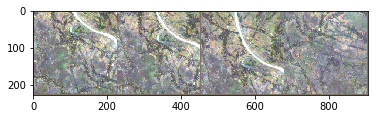

Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_7.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_8.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_9.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_10.1.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_10.2.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_11.0.tif...


In [15]:
# visualize a random batch worth of images
images, labels = next(iter(dataloders['train']))
out = torchvision.utils.make_grid(images)
torch_to_im_show(out)

In [17]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_r2 = 0.0

    losses = {'train': [], 'val': []}
    r2s = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        y_true = []
        y_pred = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                y_true += labels.numpy().tolist()

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels.float())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                preds = outputs.data
                loss = criterion(outputs, labels)

                y_pred += preds.squeeze().numpy().tolist()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                #running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_ro, epoch_p = pearsonr(y_pred, y_true)
            epoch_ro = epoch_ro ** 2
            #epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            r2s[phase].append(epoch_ro)

            print('{} Loss: {:.4f} R2: {:.4f}'.format(
                phase, epoch_loss, epoch_ro))

            # deep copy the model
            if phase == 'val' and epoch_ro > best_r2:
                best_r2 = epoch_ro
                best_model_wts = model.state_dict()

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print(losses)
    print(r2s)
    print('Best R2: {:4f}'.format(best_r2))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #return model

In [18]:
use_gpu = torch.cuda.is_available()
######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#
model_conv = torchvision.models.resnet18(pretrained=True)

######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

fine_tune = False
if fine_tune:
    for param in model_conv.parameters():
        param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

# 1 since we are only predicting household expenditure
model_conv.fc = nn.Linear(num_ftrs, 1)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.MSELoss()

params = model_conv.parameters() if fine_tune else model_conv.fc.parameters()
optimizer_conv = Adam(model_conv.fc.parameters(), 1e-3)

In [19]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [ ]:
#model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=2)
#def train_model(model, criterion, optimizer, num_epochs=25):
model = model_conv
optimizer = optimizer_conv
num_epochs = 2
since = time.time()

best_model_wts = model.state_dict()
best_r2 = 0.0

losses = {'train': [], 'val': []}
r2s = {'train': [], 'val': []}

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    y_true = []
    y_pred = []
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            #scheduler.step()
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        # running_corrects = 0

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data
            
            y_true += labels.numpy().tolist()

            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels.float())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            preds = outputs.data
            loss = criterion(outputs, labels)
            
            y_pred += preds.squeeze().numpy().tolist()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.data[0]
            #running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_ro, epoch_p = pearsonr(y_pred, y_true)
        epoch_ro = epoch_ro ** 2
        #epoch_acc = running_corrects / dataset_sizes[phase]
        
        losses[phase].append(epoch_loss)
        r2s[phase].append(epoch_ro)

        print('{} Loss: {:.4f} R2: {:.4f}'.format(
            phase, epoch_loss, epoch_ro))

        # deep copy the model
        if phase == 'val' and epoch_ro > best_r2:
            best_r2 = epoch_ro
            best_model_wts = model.state_dict()

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print(losses)
print(r2s)
print('Best R2: {:4f}'.format(best_r2))

# load best model weights
model.load_state_dict(best_model_wts)
#return model

Epoch 0/1
----------
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_1.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_2.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_3.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_4.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_5.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_6.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_7.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_8.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_9.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_10.1.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_10.2.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_11.0.tif...
Loading /mnt/mounted_bucket/l8_median_bangladesh_vis_500x500_12.0.tif...
Loading /mnt/mounted_bucket/l8_median_b

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(losses["train"], label="train")
plt.plot(losses["val"], label="val")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(r2s["train"], label="train")
plt.plot(r2s["val"], label="val")
plt.title("$R^2$ over epochs")
plt.xlabel("Epochs")
plt.legend()